# Simplified DDLBM on London Bike Sharing (ZIP + Euler-MLP)

This notebook builds a **simplified** Deep Dynamic Latent Block Model (DDLBM) in phases. We model hourly bike trips as a time-evolving Start x End station matrix, use a **Zero-Inflated Poisson (ZIP)** likelihood, and drive **time-varying cluster memberships** with an **Euler-discretized MLP** (a lightweight Neural ODE surrogate).

The focus is on interpretability and a clean, step-by-step construction rather than full-scale performance.

## Setup
This notebook uses `pandas`, `numpy`, `scipy`, `matplotlib`, `seaborn`, and `torch`. Geospatial plots optionally use `geopandas`.

In [1]:
import pathlib
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

plt.rcParams.update({"figure.figsize": (7, 4)})

## Phase 1: Data Engineering & Matrix Construction
We build a tensor `X[t, i, j]` with hourly counts of trips from Start station `i` to End station `j`.

**How this matches the paper + Script-LondonBikes.R**
- We keep weekdays only and restrict hours to 6am-10pm.
- We drop rarely used stations (usage > 50) to stabilize clusters.
- The result is a 3D tensor: hour x start-station x end-station.


In [3]:
DATA_DIR = pathlib.Path("../data")
trip_files = sorted(DATA_DIR.glob("*JourneyDataExtract*.xlsx"))

# Match the paper: weekdays, 6am-10pm window, and stations seen >50 times
TOP_N_START = None  # set to an int (e.g., 50) to force top-N pruning
TOP_N_END = None
MIN_TRIPS_PER_STATION = 50
HOUR_START = 6
HOUR_END = 22  # end-exclusive


def load_trip_data(files):
    frames = []
    usecols = ["Start Date", "StartStation Name", "EndStation Name"]
    for f in files:
        df = pd.read_excel(f, usecols=usecols)
        frames.append(df)
    df = pd.concat(frames, ignore_index=True)
    df["Start Date"] = pd.to_datetime(df["Start Date"], errors="coerce")
    df = df.dropna(subset=["Start Date", "StartStation Name", "EndStation Name"])
    df["hour"] = df["Start Date"].dt.hour
    df["weekday"] = df["Start Date"].dt.day_name()
    return df

trips = load_trip_data(trip_files)

# Weekdays only, and 6am-10pm (like Script-LondonBikes.R)
trips = trips[trips["weekday"].isin(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])]
trips = trips[(trips["hour"] >= HOUR_START) & (trips["hour"] < HOUR_END)]

# Filter stations by minimum usage
start_counts = trips["StartStation Name"].value_counts()
end_counts = trips["EndStation Name"].value_counts()
keep_start = start_counts[start_counts > MIN_TRIPS_PER_STATION].index
keep_end = end_counts[end_counts > MIN_TRIPS_PER_STATION].index
trips = trips[trips["StartStation Name"].isin(keep_start) & trips["EndStation Name"].isin(keep_end)]

# Optional: further prune to top-N stations
if TOP_N_START is not None:
    top_starts = trips["StartStation Name"].value_counts().head(TOP_N_START).index
    trips = trips[trips["StartStation Name"].isin(top_starts)]
if TOP_N_END is not None:
    top_ends = trips["EndStation Name"].value_counts().head(TOP_N_END).index
    trips = trips[trips["EndStation Name"].isin(top_ends)]

start_names = sorted(trips["StartStation Name"].unique())
end_names = sorted(trips["EndStation Name"].unique())
start_idx = {name: i for i, name in enumerate(start_names)}
end_idx = {name: i for i, name in enumerate(end_names)}

counts = (
    trips.groupby(["hour", "StartStation Name", "EndStation Name"])
    .size()
    .reset_index(name="count")
)

T = HOUR_END - HOUR_START
N = len(start_names)
M = len(end_names)

slices = []
for h in range(HOUR_START, HOUR_END):
    sub = counts[counts["hour"] == h]
    if sub.empty:
        slices.append(sp.coo_matrix((N, M)))
        continue
    rows = sub["StartStation Name"].map(start_idx).to_numpy()
    cols = sub["EndStation Name"].map(end_idx).to_numpy()
    data = sub["count"].to_numpy()
    mat = sp.coo_matrix((data, (rows, cols)), shape=(N, M))
    slices.append(mat)

X = np.stack([s.toarray() for s in slices], axis=0)
print("Tensor shape (T, N, M):", X.shape)


Tensor shape (T, N, M): (16, 791, 791)


In [4]:
# Quick sanity checks on the filtered data
print("Trips after filtering:", len(trips))
print("Start stations:", len(start_names), "End stations:", len(end_names))
print("Hours:", list(range(HOUR_START, HOUR_END)))


Trips after filtering: 819340
Start stations: 791 End stations: 791
Hours: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


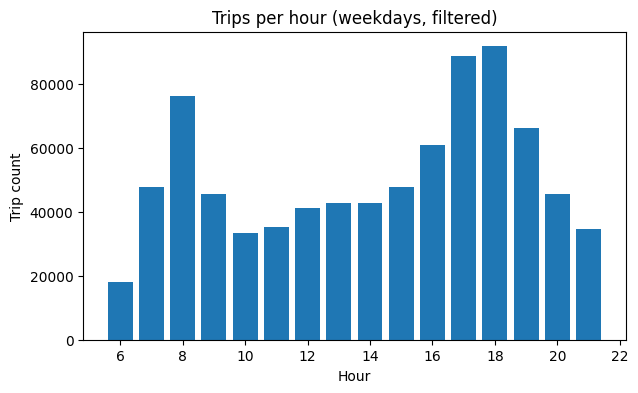

In [5]:
# Hourly volume profile (should show morning/evening peaks)
hour_counts = trips["hour"].value_counts().sort_index()
plt.figure()
plt.bar(hour_counts.index, hour_counts.values, color="#1f77b4")
plt.title("Trips per hour (weekdays, filtered)")
plt.xlabel("Hour")
plt.ylabel("Trip count")
plt.show()


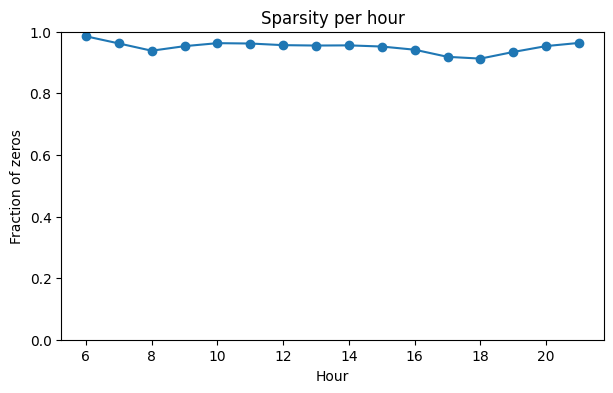

In [6]:
# Sparsity level per hour: fraction of zeros in X(t)
zero_frac = []
for t in range(T):
    zero_frac.append((X[t] == 0).mean())
plt.figure()
plt.plot(range(HOUR_START, HOUR_END), zero_frac, marker="o")
plt.title("Sparsity per hour")
plt.xlabel("Hour")
plt.ylabel("Fraction of zeros")
plt.ylim(0, 1)
plt.show()


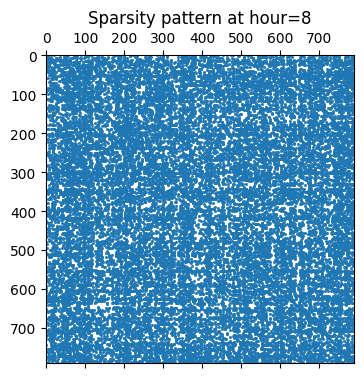

In [7]:
t_show = 8  # 8 AM
plt.figure()
plt.title(f"Sparsity pattern at hour={t_show}")
plt.spy(slices[t_show], markersize=1)
plt.show()

**Intuition: What the model is trying to discover**
- Each hour is a matrix of Start x End station interactions.
- A block (q, l) says: “start stations in group q tend to send bikes to end stations in group l.”
- Lambda[q, l] is the expected trip intensity of that block.
- The assignments evolve over time, capturing daily role changes of stations.


## Phase 2: Defining Latent Block Parameters
We initialize block intensities `Lambda` and a ZIP sparsity parameter `pi`. We also initialize per-station cluster logits and let them drift over time using Euler updates.

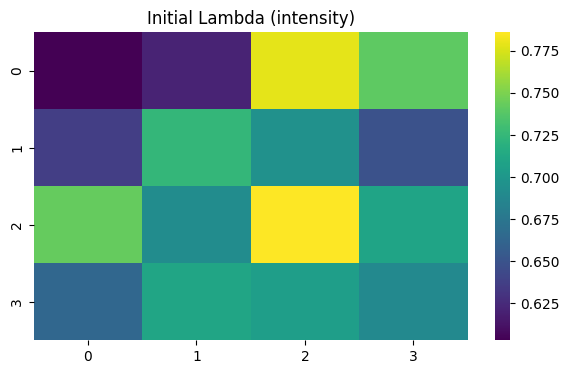

In [8]:
Q = 4  # start clusters
L = 4  # end clusters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_torch = torch.tensor(X, dtype=torch.float32, device=device)

Lambda_raw = nn.Parameter(torch.randn(Q, L, device=device) * 0.1)
pi_logit = nn.Parameter(torch.tensor(0.0, device=device))

a0 = nn.Parameter(torch.randn(N, Q, device=device) * 0.1)
b0 = nn.Parameter(torch.randn(M, L, device=device) * 0.1)

class EulerMLP(nn.Module):
    def __init__(self, dim, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, dim),
        )

    def forward(self, x):
        return self.net(x)

f_row = EulerMLP(Q, hidden=32).to(device)
f_col = EulerMLP(L, hidden=32).to(device)

def evolve_logits(a_init, f, steps):
    logits = [a_init]
    a = a_init
    for _ in range(steps - 1):
        a = a + f(a)
        logits.append(a)
    return logits

def zip_log_likelihood(x, rate, pi):
    rate = torch.clamp(rate, min=1e-6)
    log_p0 = torch.log(pi + (1.0 - pi) * torch.exp(-rate))
    log_pk = torch.log(1.0 - pi) + x * torch.log(rate) - rate - torch.lgamma(x + 1.0)
    return torch.where(x == 0, log_p0, log_pk)

plt.figure()
sns.heatmap(F.softplus(Lambda_raw).detach().cpu().numpy(), cmap="viridis")
plt.title("Initial Lambda (intensity)")
plt.show()

**ZIP intuition**
- In sparse data, many zeros are structural (no interaction), not just “small counts.”
- ZIP models this by mixing a **spike at zero** with a Poisson count process.
- The parameter `pi` is the probability of a structural zero.


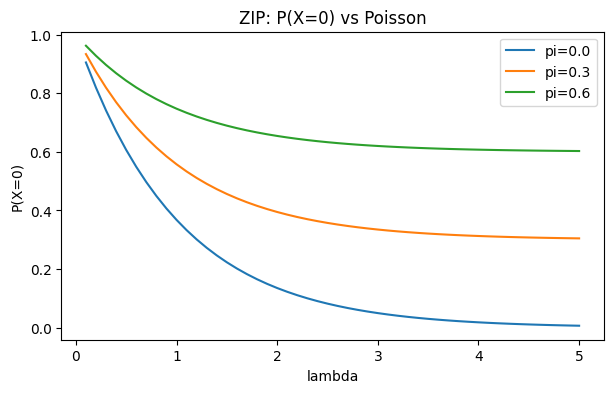

In [9]:
# Visualize how ZIP increases P(X=0) beyond Poisson
lambdas = np.linspace(0.1, 5.0, 50)
pi_vals = [0.0, 0.3, 0.6]
plt.figure()
for pi in pi_vals:
    p0 = pi + (1 - pi) * np.exp(-lambdas)
    plt.plot(lambdas, p0, label=f"pi={pi}")
plt.title("ZIP: P(X=0) vs Poisson")
plt.xlabel("lambda")
plt.ylabel("P(X=0)")
plt.legend()
plt.show()


**Dynamics intuition (Euler-MLP)**
- We keep a set of logits for each station and cluster.
- A small MLP produces a “velocity” for those logits.
- Euler steps approximate a Neural ODE: `a(t+1) = a(t) + f(a(t))`.
- Softmax turns logits into cluster probabilities.


## Phase 3 & 4: Dynamics + ZIP Loss (Variational-Style Training)
We optimize `Lambda`, `pi`, and the Euler-MLP parameters by maximizing the ZIP log-likelihood across time.

In [10]:
# Shape check: how block intensities map to station-pair rates
print("tau shape:", tuple(F.softmax(evolve_logits(a0, f_row, T)[0], dim=1).shape))
print("eta shape:", tuple(F.softmax(evolve_logits(b0, f_col, T)[0], dim=1).shape))
print("Lambda shape:", tuple(F.softplus(Lambda_raw).shape))


tau shape: (791, 4)
eta shape: (791, 4)
Lambda shape: (4, 4)


In [11]:
params = [Lambda_raw, pi_logit, a0, b0] + list(f_row.parameters()) + list(f_col.parameters())
opt = torch.optim.Adam(params, lr=1e-2)

NUM_EPOCHS = 200

for epoch in range(NUM_EPOCHS):
    logits_a = evolve_logits(a0, f_row, T)
    logits_b = evolve_logits(b0, f_col, T)

    Lambda = F.softplus(Lambda_raw)
    pi = torch.sigmoid(pi_logit)

    total_loglik = 0.0
    for t in range(T):
        tau = F.softmax(logits_a[t], dim=1)
        eta = F.softmax(logits_b[t], dim=1)
        rate = tau @ Lambda @ eta.T
        total_loglik = total_loglik + zip_log_likelihood(X_torch[t], rate, pi).sum()

    loss = -total_loglik
    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch % 25 == 0:
        print(f"epoch={epoch:03d} loss={loss.item():.2f} pi={pi.item():.3f}")

epoch=000 loss=4008672.25 pi=0.500
epoch=025 loss=3420439.75 pi=0.560
epoch=050 loss=3123641.75 pi=0.612
epoch=075 loss=2964035.25 pi=0.652
epoch=100 loss=2880230.25 pi=0.684
epoch=125 loss=2830726.00 pi=0.709
epoch=150 loss=2796412.75 pi=0.729
epoch=175 loss=2772062.00 pi=0.747


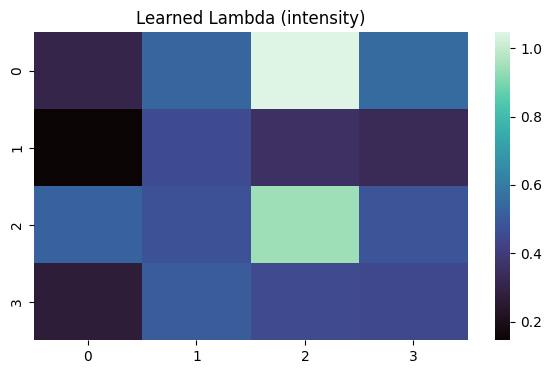

In [12]:
Lambda = F.softplus(Lambda_raw).detach().cpu().numpy()
plt.figure()
sns.heatmap(Lambda, cmap="mako")
plt.title("Learned Lambda (intensity)")
plt.show()

## Phase 3 Visualization: Cluster Drift Over 24 Hours
We look at how average cluster proportions evolve through the day.

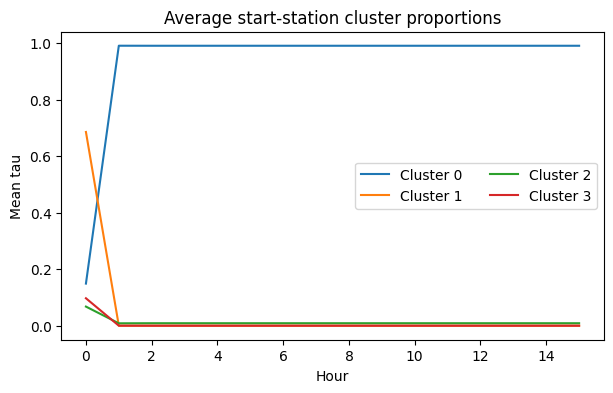

In [13]:
with torch.no_grad():
    logits_a = evolve_logits(a0, f_row, T)
    alpha_series = []
    for t in range(T):
        tau = F.softmax(logits_a[t], dim=1)
        alpha_series.append(tau.mean(dim=0).cpu().numpy())

alpha_series = np.stack(alpha_series, axis=0)

plt.figure()
for q in range(Q):
    plt.plot(alpha_series[:, q], label=f"Cluster {q}")
plt.title("Average start-station cluster proportions")
plt.xlabel("Hour")
plt.ylabel("Mean tau")
plt.legend(ncol=2)
plt.show()

## Phase 5: Graph Clustering & Re-ordering
We reorder the matrix by learned cluster assignments to reveal block structure.

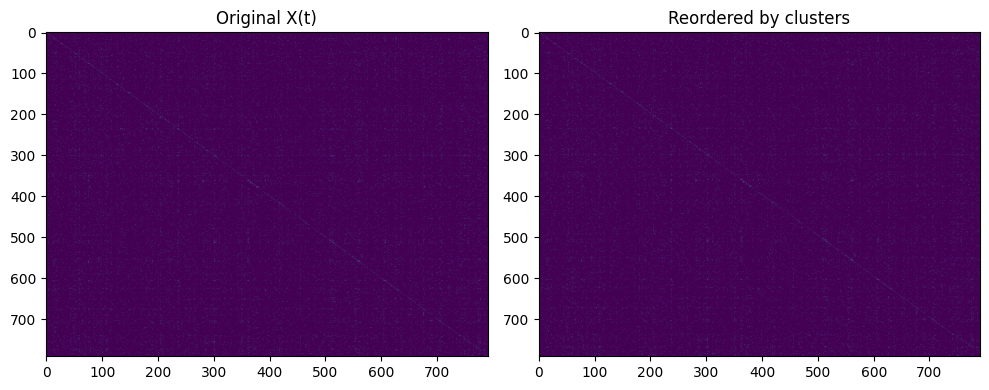

In [14]:
t_show = 8
with torch.no_grad():
    tau = F.softmax(evolve_logits(a0, f_row, T)[t_show], dim=1).cpu().numpy()
    eta = F.softmax(evolve_logits(b0, f_col, T)[t_show], dim=1).cpu().numpy()

row_labels = tau.argmax(axis=1)
col_labels = eta.argmax(axis=1)

row_order = np.lexsort((np.arange(N), row_labels))
col_order = np.lexsort((np.arange(M), col_labels))

orig = X[t_show]
reordered = orig[row_order][:, col_order]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(np.log1p(orig), aspect="auto", cmap="viridis")
axes[0].set_title("Original X(t)")
axes[1].imshow(np.log1p(reordered), aspect="auto", cmap="viridis")
axes[1].set_title("Reordered by clusters")
plt.tight_layout()
plt.show()

**Reading the reordered matrix**
- If the model works, reordered X(t) should show dense blocks.
- Each block corresponds to a pair of station communities.
- The structure gives a quick “who-commutes-to-whom” view.


In [15]:
# List top stations by cluster at a given hour
show_hour = 8
with torch.no_grad():
    tau = F.softmax(evolve_logits(a0, f_row, T)[show_hour], dim=1).cpu().numpy()

cluster_ids = tau.argmax(axis=1)

cluster_to_stations = {}
for idx, c in enumerate(cluster_ids):
    cluster_to_stations.setdefault(c, []).append(start_names[idx])

for c in sorted(cluster_to_stations):
    print(f"Cluster {c}: {cluster_to_stations[c][:10]}")


Cluster 0: ['Abbey Orchard Street, Westminster', 'Abbotsbury Road, Holland Park', "Aberdeen Place, St. John's Wood", 'Aberfeldy Street, Poplar', 'Abingdon Green, Westminster', 'Abingdon Villas, Kensington', 'Abyssinia Close, Clapham Junction', 'Ackroyd Drive, Bow', 'Ada Street, Hackney Central', 'Addison Road, Holland Park']
Cluster 2: ["Belgrove Street , King's Cross", 'Boston Place, Marylebone', 'London Fields, Hackney Central', 'Waterloo Station 1, Waterloo', 'Waterloo Station 2, Waterloo', 'Waterloo Station 3, Waterloo', 'Wormwood Street, Liverpool Street']


**Station roles can change with time**
- We can compare 8am vs 6pm assignments to see commuting patterns.
- A station can behave like a “source” in the morning and a “sink” in the evening.


In [35]:
# How many stations switch clusters between morning and evening?
with torch.no_grad():
    tau_8 = F.softmax(evolve_logits(a0, f_row, T)[0], dim=1).cpu().numpy().argmax(axis=1)
    tau_18 = F.softmax(evolve_logits(a0, f_row, T)[15], dim=1).cpu().numpy().argmax(axis=1)

switch_rate = (tau_8 != tau_18).mean()
print(f"Fraction of start stations that switch cluster (8am vs 6pm): {switch_rate:.2%}")


Fraction of start stations that switch cluster (8am vs 6pm): 95.83%


## Phase 6: Geospatial Interpretation
We color stations by their assigned start-cluster at 8 AM vs. 6 PM.

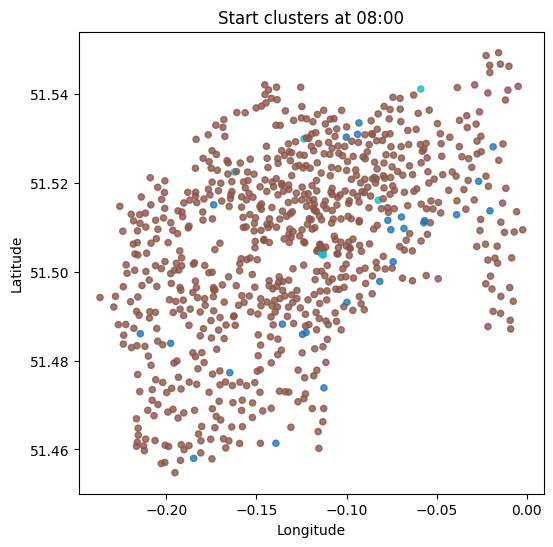

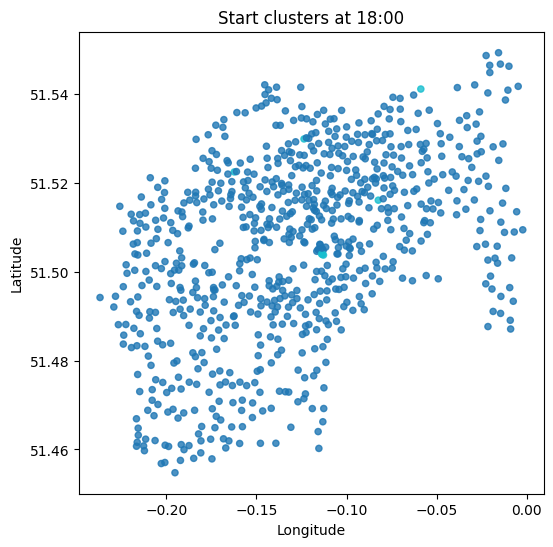

In [36]:
points = pd.read_excel(DATA_DIR / "bike-points.xlsx")
points = points.rename(columns={"name": "Station Name"})
points = points[points["Station Name"].isin(start_names)].copy()

name_to_idx = {name: i for i, name in enumerate(start_names)}
points["station_idx"] = points["Station Name"].map(name_to_idx)

def plot_station_clusters(points_df, cluster_ids, title):
    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(
        points_df["longitude"],
        points_df["latitude"],
        c=cluster_ids,
        cmap="tab10",
        s=20,
        alpha=0.8,
    )
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

with torch.no_grad():
    tau_8 = F.softmax(evolve_logits(a0, f_row, T)[0], dim=1).cpu().numpy()
    tau_18 = F.softmax(evolve_logits(a0, f_row, T)[15], dim=1).cpu().numpy()

cluster_8 = tau_8.argmax(axis=1)
cluster_18 = tau_18.argmax(axis=1)

points_8 = points.copy()
points_8["cluster"] = points_8["station_idx"].map(lambda i: cluster_8[i])
points_18 = points.copy()
points_18["cluster"] = points_18["station_idx"].map(lambda i: cluster_18[i])

plot_station_clusters(points_8, points_8["cluster"], "Start clusters at 08:00")
plot_station_clusters(points_18, points_18["cluster"], "Start clusters at 18:00")

## What This Notebook Simplifies (vs the paper)
- **Inference**: replaces the full VEM (variational E-step + M-step) with direct ZIP log-likelihood optimization.
- **Latent variables**: we do not explicitly model `A` (zero-inflation indicator) or maintain variational distributions `tau`, `eta`, `delta`; we use softmax outputs directly.
- **Dynamics**: uses a single Euler step per hour (discrete-time MLP) instead of continuous-time Neural ODEs and separate ODEs for `alpha`, `beta`, and `pi`.
- **Sparsity**: `pi` is global (single scalar) instead of time-varying `pi(t)`.
- **Initialization/model selection**: skips the paper’s ICL-based model selection and cascade initialization.
- **Scale**: optional top-N pruning and use of dense tensors for clarity rather than optimized sparse computations.
- **Station clusters**: no label-switching correction or identifiability constraints beyond softmax.
